In [8]:
#!pip install qiskit==1.1.0 qiskit-aer==0.14.2 qiskit-algorithms==0.3.0 qiskit-ibm-runtime==0.25.0 qiskit-machine-learning==0.7.2 qiskit-nature==0.7.2 qiskit-nature-pyscf==0.4.0 qiskit-qasm3-import==0.5.0 qiskit-transpiler-service==0.4.5
#!pip install pylatexenc #!pip install pylatexenc matplotlib

In [2]:
import numpy as np
import pylab

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit.visualization import matplotlib
from qiskit.circuit.library import EfficientSU2, TwoLocal
from qiskit_algorithms.optimizers import SLSQP

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke, FakeKyoto, FakeBrisbane
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_algorithms import VQE
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize

from qiskit_algorithms.minimum_eigensolvers import MinimumEigensolverResult
import numpy as np
import matplotlib.pyplot as plt
import pickle

## H2O

In [12]:
driver = PySCFDriver(atom='O 0.0000  0.0000  0.1173; H 0.0000  0.7572  -0.4692; H 0.0000  -0.7572  -0.4692', charge=0, spin=0, basis='sto3g')
molecule = driver.run()

print(f'Nuclear repulsion energy: {molecule.nuclear_repulsion_energy} Ha')
print(f'Reference energy: {molecule.reference_energy} Ha')
print(f'Number of spin orbitals: {molecule.num_spin_orbitals}')
print(f'Number of alpha electrons: {molecule.num_alpha}')
print(f'Number of beta electrons: {molecule.num_beta}')
print(f'Number of 2nd quantized ops terms: {len(molecule.second_q_ops()[0])}')

ref_energy = molecule.reference_energy # Total ground state energy

Nuclear repulsion energy: 9.189533762934902 Ha
Reference energy: -74.96302313846124 Ha
Number of spin orbitals: 14
Number of alpha electrons: 5
Number of beta electrons: 5
Number of 2nd quantized ops terms: 3150


In [13]:
# parity mapping
mapper = ParityMapper(num_particles=molecule.num_particles)
algo = NumPyMinimumEigensolver()
algo.filter_criterion = molecule.get_default_filter_criterion()
solver = GroundStateEigensolver(mapper, algo)
op, _ = solver.get_qubit_operators(molecule)
print(f'Number of qubits: {op.num_qubits}, number of paulis: {len(op.paulis)}')
result = solver.solve(molecule)
print(result)

Number of qubits: 12, number of paulis: 1086
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -84.202112004027
  - computed part:      -84.202112004027
~ Nuclear repulsion energy (Hartree): 9.189533762935
> Total ground state energy (Hartree): -75.012578241092
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 10.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  0.0]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  0.635779526367]
    - computed part:      [0.0  0.0  0.635779526367]
  > Dipole moment (a.u.): [0.0  0.0  -0.635779526367]  Total: 0.635779526367
                 (debye): [0.0  0.0  -1.615990214926]  Total: 1.615990214926
 


In [14]:
# Freeze the core electrons
transformer = FreezeCoreTransformer()
transformed_molecule = transformer.transform(molecule)
mapper = ParityMapper(num_particles=transformed_molecule.num_particles)

algo = NumPyMinimumEigensolver()
algo.filter_criterion = transformed_molecule.get_default_filter_criterion()
solver = GroundStateEigensolver(mapper, algo)
op, _ = solver.get_qubit_operators(transformed_molecule)
print(f'Number of qubits: {op.num_qubits}, number of paulis: {len(op.paulis)}')
result = solver.solve(transformed_molecule)
print(result)

Number of qubits: 10, number of paulis: 551
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -84.202033916877
  - computed part:      -23.541330525005
  - FreezeCoreTransformer extracted energy part: -60.660703391873
~ Nuclear repulsion energy (Hartree): 9.189533762935
> Total ground state energy (Hartree): -75.012500153943
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 8.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  0.0]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  0.635838740643]
    - computed part:      [0.0  0.0  0.19339305473]
    - FreezeCoreTransformer extracted energy part: [0.0  0.0  0.442445685913]
  > Dipole moment (a.u.): [0.0  0.0  -0.635838740643]  Total: 0.635838740643
                 (debye): [0.0  0.0  -1.616140722588]  Total: 1.616140722588
 


In [15]:
print(f'Before FC: # particles: {molecule.num_particles}, # spatial orbitals: {molecule.num_spatial_orbitals}')
print(f'After FC: # particles: {transformed_molecule.num_particles}, # spatial orbitals: {transformed_molecule.num_spatial_orbitals}')

Before FC: # particles: (5, 5), # spatial orbitals: 7
After FC: # particles: (4, 4), # spatial orbitals: 6


In [16]:
# Reducing the problem to the active space containing the 2 electrons in the 3 spatial orbitals
active_space_transformer = ActiveSpaceTransformer(num_electrons=4, num_spatial_orbitals=4)
reduced_molecule_problem = active_space_transformer.transform(transformed_molecule)

In [17]:
print('Number of 2nd quantized op terms after core freezing:', len(transformed_molecule.second_q_ops()[0]))
second_q_hamiltonian = reduced_molecule_problem.second_q_ops()[0]
print('Number of 2nd qu op terms after orbital reduction:',len(second_q_hamiltonian))

Number of 2nd quantized op terms after core freezing: 1596
Number of 2nd qu op terms after orbital reduction: 300


In [18]:
mapper = ParityMapper(num_particles=reduced_molecule_problem.num_particles)

algo = NumPyMinimumEigensolver()
algo.filter_criterion = reduced_molecule_problem.get_default_filter_criterion()
solver = GroundStateEigensolver(mapper, algo)
op, _ = solver.get_qubit_operators(reduced_molecule_problem)
print(f'Number of qubits: {op.num_qubits}, number of paulis: {len(op.paulis)}')
result = solver.solve(reduced_molecule_problem)
print(result)

Number of qubits: 6, number of paulis: 95
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -84.159988140693
  - computed part:      -6.162434053748
  - FreezeCoreTransformer extracted energy part: -60.660703391873
  - ActiveSpaceTransformer extracted energy part: -17.336850695072
~ Nuclear repulsion energy (Hartree): 9.189533762935
> Total ground state energy (Hartree): -74.970454377758
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 4.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  0.0]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  0.653838454304]
    - computed part:      [0.0  0.0  1.024043289811]
    - FreezeCoreTransformer extracted energy part: [0.0  0.0  0.442445685913]
    - ActiveSpaceTransformer extracted energy part: [0.0  0.0  -0.81265052142]
  > Dipole moment (a.u.): [0.0  0.0  -0.653838454304]  Total: 0.653838454304
                 (debye): [0.0  0.0  -1.661891426945]  Total: 1.

In [19]:
# Total ground state energy = Nuclear repulsion energy+ActiveSpaceTransformer extracted energy part+FreezeCoreTransformer extracted energy part+computed part (free electrons)
cst_energy = 9.189533762935-17.336850695072-60.660703391873

### This part for all the molecules

In [10]:
# Applying the Parity Mapping
hamiltonian = op #mapper.map(second_q_hamiltonian)
print(hamiltonian)

SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIZX', 'IIIIIIIIIIIX', 'IIIIIIIZXXXX', 'IIIIIIIIYXXY', 'IIIIIIXXXXXX', 'IIIIIIYXXXXY', 'IIIIIIIIIIZZ', 'IIIIIIIZXXXZ', 'IIIIIIIIYXYI', 'IIIIIIXXXXXZ', 'IIIIIIYXXXYI', 'IIIIIIIIIZZI', 'IIIIIIIIZXZI', 'IIIIIIIIIXII', 'IIIIIIZXXXZI', 'IIIIIIIYXYII', 'IIIIIIIIZZII', 'IIIIIIZXXZII', 'IIIIIIIYYIII', 'IIIIIIIZZIII', 'IIIIIIXXZIII', 'IIIIIIYYIIII', 'IIIIIIZZIIII', 'IIIIIIZIIIII', 'IIIIIZIIIIII', 'IIIIZXIIIIII', 'IIIIIXIIIIII', 'IZXXXXIIIIII', 'IIYXXYIIIIII', 'XXXXXXIIIIII', 'YXXXXYIIIIII', 'IIIIZZIIIIII', 'IZXXXZIIIIII', 'IIYXYIIIIIII', 'XXXXXZIIIIII', 'YXXXYIIIIIII', 'IIIZZIIIIIII', 'IIZXZIIIIIII', 'IIIXIIIIIIII', 'ZXXXZIIIIIII', 'IYXYIIIIIIII', 'IIZZIIIIIIII', 'ZXXZIIIIIIII', 'IYYIIIIIIIII', 'IZZIIIIIIIII', 'XXZIIIIIIIII', 'YYIIIIIIIIII', 'ZZIIIIIIIIII', 'ZIIIIIIIIIII', 'IIIIIIIIIIZI', 'IIIIIIIZXXXI', 'IIIIIIIIYXYZ', 'IIIIIIXXXXXI', 'IIIIIIYXXXYZ', 'IIIIIIIIIZZZ', 'IIIIIIIIZXZZ', 'IIIIIIIIIXIZ', 'IIIIIIZXXXZZ', 'IIIIIIIYXYIZ', 'IIIIIIII

In [11]:
target_energy = np.linalg.eigvalsh(hamiltonian.to_matrix())[0]
target_energy # computed part

np.float64(-20.498586135338627)

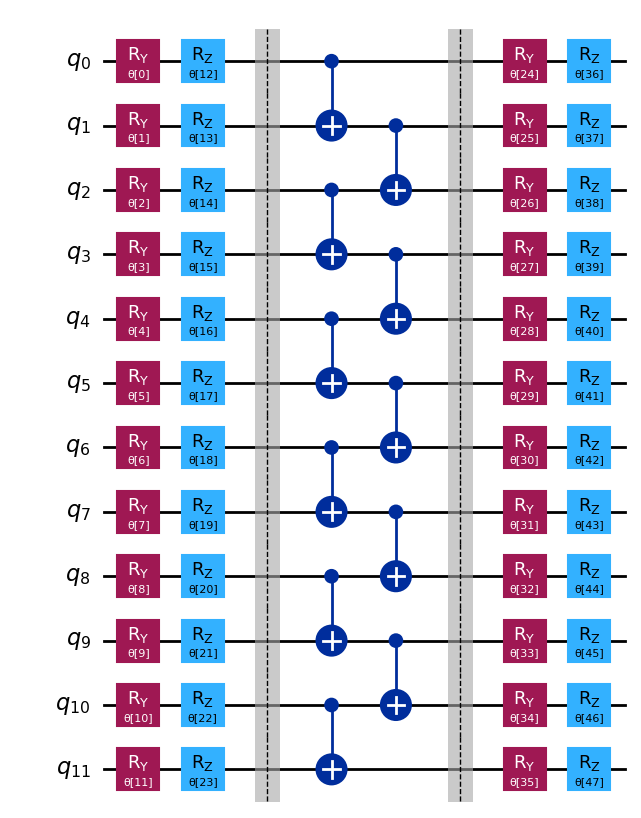

In [12]:
num_qubits = hamiltonian.num_qubits
rotation_blocks = ['ry','rz']
entanglement_blocks = 'cx'
entanglement = 'pairwise'

ansatz = TwoLocal(num_qubits, rotation_blocks, entanglement_blocks, entanglement, reps=1, insert_barriers=True).decompose()
ansatz.draw('mpl')

In [13]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"].append(params)
    cost_history_dict["cost_history"].append(energy+cst_energy)
    print(f"Iters: {cost_history_dict['iters']} [Current energy: {energy+cst_energy}]")

    return energy

In [14]:
aer_sim = AerSimulator()
cost_history_dict = {"prev_vector": [], "iters": 0, "cost_history": []}
x0 = 2 * np.pi * np.random.random(ansatz.num_parameters)
x0

array([2.90090129, 5.02191277, 5.05213758, 4.98826628, 4.07580029,
       4.42586888, 3.49327371, 5.28778636, 4.8747677 , 6.09390382,
       0.28729069, 1.12616029, 6.09420623, 1.3714558 , 5.06672599,
       1.43820803, 5.0008586 , 4.1382564 , 5.64223396, 6.04302702,
       0.98647909, 2.03358359, 1.10709423, 3.33063992, 0.75522652,
       2.15357125, 2.27206144, 3.65319684, 2.03446728, 0.0151378 ,
       5.98849641, 4.8087879 , 2.18261056, 0.31024316, 4.22707927,
       0.85516667, 1.11791845, 1.85150484, 2.05783678, 0.14752476,
       5.88028937, 4.60723075, 1.96959881, 1.12215353, 5.20635909,
       4.77477162, 0.32922521, 5.51456339])

In [15]:
with Session(backend=aer_sim) as session:
    estimator = Estimator(mode=session)

    res = minimize(cost_func, x0, args=(ansatz, hamiltonian, estimator),
                   method="cobyla", options={'maxiter': 200})

Iters: 1 [Current energy: -684.6108166818947]
Iters: 2 [Current energy: -684.4512279544148]
Iters: 3 [Current energy: -684.9076480256683]
Iters: 4 [Current energy: -685.0784844243573]
Iters: 5 [Current energy: -685.483212430653]
Iters: 6 [Current energy: -685.2441211048628]
Iters: 7 [Current energy: -685.7610738372053]
Iters: 8 [Current energy: -685.7852479025804]
Iters: 9 [Current energy: -686.0536149995354]
Iters: 10 [Current energy: -686.2481195796585]
Iters: 11 [Current energy: -686.2467148575976]
Iters: 12 [Current energy: -686.1441274964502]
Iters: 13 [Current energy: -686.3376635556974]
Iters: 14 [Current energy: -686.3433225823544]
Iters: 15 [Current energy: -686.2438673528553]
Iters: 16 [Current energy: -686.2693013117666]
Iters: 17 [Current energy: -686.4092632615466]
Iters: 18 [Current energy: -686.5533762096127]
Iters: 19 [Current energy: -686.2903561854375]
Iters: 20 [Current energy: -686.5775427910127]
Iters: 21 [Current energy: -686.5087313982473]
Iters: 22 [Current ener

In [16]:
# Download the data
with open('egypt_ideal_vqe_H2SO3_data.pkl', 'wb') as file:
    pickle.dump(cost_history_dict, file)

In [17]:
from google.colab import files
files.download('egypt_ideal_vqe_H2SO3_data.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
# Upload the data
#from google.colab import files
#uploaded = files.upload()

Saving egypt_ideal_vqe_SO3_data (1).pkl to egypt_ideal_vqe_SO3_data (1) (1).pkl


In [5]:
#with open('egypt_ideal_vqe_SO3_data (1).pkl', 'rb') as f:
#    cost_history_dict = pickle.load(f)

In [19]:
print('Ground energy estimated for H2SO3:',min(cost_history_dict['cost_history']))

Ground energy estimated for H2SO3: -688.1991870300016


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

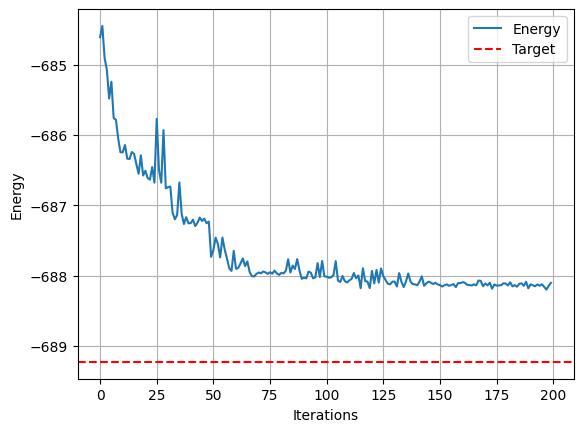

In [20]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"], label='Energy')
plt.axhline(ref_energy, c='r', ls='--',label='Target')

ax.set_xlabel("Iterations")
ax.set_ylabel("Energy")
plt.draw()
plt.legend()
plt.grid()
#plt.tight_layout()
plt.savefig('egypt_ideal_vqe_H2SO3_fig.png')
files.download('egypt_ideal_vqe_H2SO3_fig.png')
plt.show()

## SO3

In [3]:
driver = PySCFDriver(atom='S 0.0000  0.0000  0.0000; O 0.0000  1.4175  0.0000; O  1.2276  -0.7088  0.0000; O  -1.2276  -0.7088  0.0000', charge=0, spin=0, basis='sto3g')
molecule = driver.run()


print(f'Nuclear repulsion energy: {molecule.nuclear_repulsion_energy} Ha')
print(f'Reference energy: {molecule.reference_energy} Ha')
print(f'Number of spin orbitals: {molecule.num_spin_orbitals}')
print(f'Number of alpha electrons: {molecule.num_alpha}')
print(f'Number of beta electrons: {molecule.num_beta}')
print(f'Number of 2nd quantized ops terms: {len(molecule.second_q_ops()[0])}')

ref_energy = molecule.reference_energy # Total ground state energy

Nuclear repulsion energy: 184.73366307896137 Ha
Reference energy: -614.2315439258371 Ha
Number of spin orbitals: 48
Number of alpha electrons: 20
Number of beta electrons: 20
Number of 2nd quantized ops terms: 368916


In [4]:
# Freeze the core electrons
transformer = FreezeCoreTransformer()
transformed_molecule = transformer.transform(molecule)
print(f'Number of 2nd quantized ops terms: {len(transformed_molecule.second_q_ops()[0])}')

Number of 2nd quantized ops terms: 70040


In [5]:
print(f'Before FC: # particles: {molecule.num_particles}, # spatial orbitals: {molecule.num_spatial_orbitals}')
print(f'After FC: # particles: {transformed_molecule.num_particles}, # spatial orbitals: {transformed_molecule.num_spatial_orbitals}')

Before FC: # particles: (20, 20), # spatial orbitals: 24
After FC: # particles: (12, 12), # spatial orbitals: 16


In [6]:
# Reducing the problem to the active space containing the 12 electrons in the 10 spatial orbitals
active_space_transformer = ActiveSpaceTransformer(num_electrons=8, num_spatial_orbitals=6)
reduced_molecule_problem = active_space_transformer.transform(transformed_molecule)

In [7]:
print('Number of 2nd quantized op terms after core freezing:', len(transformed_molecule.second_q_ops()[0]))
second_q_hamiltonian = reduced_molecule_problem.second_q_ops()[0]
print('Number of 2nd qu op terms after orbital reduction:',len(second_q_hamiltonian))

Number of 2nd quantized op terms after core freezing: 70040
Number of 2nd qu op terms after orbital reduction: 1332


In [8]:
mapper = ParityMapper(num_particles=reduced_molecule_problem.num_particles)

algo = NumPyMinimumEigensolver()
algo.filter_criterion = reduced_molecule_problem.get_default_filter_criterion()
solver = GroundStateEigensolver(mapper, algo)
op, _ = solver.get_qubit_operators(reduced_molecule_problem)
print(f'Number of qubits: {op.num_qubits}, number of paulis: {len(op.paulis)}')
result = solver.solve(reduced_molecule_problem)
print(result)

Number of qubits: 10, number of paulis: 471
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -799.048461577294
  - computed part:      -13.90295848874
  - FreezeCoreTransformer extracted energy part: -679.90691005092
  - ActiveSpaceTransformer extracted energy part: -105.238593037634
~ Nuclear repulsion energy (Hartree): 184.733663078961
> Total ground state energy (Hartree): -614.314798498332
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 8.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  -0.00151178  0.0]
 
  0: 
  * Electronic dipole moment (a.u.): [-0.000000000001  -0.00156226102  0.0]
    - computed part:      [0.0  -0.003701777848  0.0]
    - FreezeCoreTransformer extracted energy part: [0.0  -0.000378019131  0.0]
    - ActiveSpaceTransformer extracted energy part: [-0.000000000001  0.002517535959  0.0]
  > Dipole moment (a.u.): [0.000000000001  0.00005048102  0.0]  Total: 0.00005048102
               

In [9]:
cst_energy = 184.733663078961 - 105.238593037634 - 679.90691005092 # NR + AS + FC

## H2SO4

In [3]:
driver = PySCFDriver(atom='S   0.0000    0.0000    0.1248; O    1.2510    -0.0349    0.8000; O    -1.2510    0.0349    0.8000; O    0.0000    -1.2172    -0.8732; O    0.0000    1.2172    -0.8732; H    -0.3548    1.9933    -0.4121; H    0.3548    -1.9933    -0.4121', charge=0, spin=0, basis='sto3g')
molecule = driver.run()

print(f'Nuclear repulsion energy: {molecule.nuclear_repulsion_energy} Ha')
print(f'Reference energy: {molecule.reference_energy} Ha')
print(f'Number of spin orbitals: {molecule.num_spin_orbitals}')
print(f'Number of alpha electrons: {molecule.num_alpha}')
print(f'Number of beta electrons: {molecule.num_beta}')
print(f'Number of 2nd quantized ops terms: {len(molecule.second_q_ops()[0])}')

ref_energy = molecule.reference_energy # Total ground state energy

Nuclear repulsion energy: 290.7294395071391 Ha
Reference energy: -689.2267909831724 Ha
Number of spin orbitals: 62
Number of alpha electrons: 25
Number of beta electrons: 25
Number of 2nd quantized ops terms: 1840086


In [4]:
# Freeze the core electrons
transformer = FreezeCoreTransformer()
transformed_molecule = transformer.transform(molecule)
print(f'Number of 2nd quantized ops terms: {len(transformed_molecule.second_q_ops()[0])}')

Number of 2nd quantized ops terms: 468996


In [5]:
print(f'Before FC: # particles: {molecule.num_particles}, # spatial orbitals: {molecule.num_spatial_orbitals}')
print(f'After FC: # particles: {transformed_molecule.num_particles}, # spatial orbitals: {transformed_molecule.num_spatial_orbitals}')

Before FC: # particles: (25, 25), # spatial orbitals: 31
After FC: # particles: (16, 16), # spatial orbitals: 22


In [6]:
# Reducing the problem to the active space containing the 10 electrons in the 7 spatial orbitals
active_space_transformer = ActiveSpaceTransformer(num_electrons=10, num_spatial_orbitals=7)
reduced_molecule_problem = active_space_transformer.transform(transformed_molecule)

In [7]:
print('Number of 2nd quantized op terms after core freezing:', len(transformed_molecule.second_q_ops()[0]))
second_q_hamiltonian = reduced_molecule_problem.second_q_ops()[0]
print('Number of 2nd qu op terms after orbital reduction:',len(second_q_hamiltonian))

Number of 2nd quantized op terms after core freezing: 468996
Number of 2nd qu op terms after orbital reduction: 4854


In [8]:
mapper = ParityMapper(num_particles=reduced_molecule_problem.num_particles)

algo = NumPyMinimumEigensolver()
algo.filter_criterion = reduced_molecule_problem.get_default_filter_criterion()
solver = GroundStateEigensolver(mapper, algo)
op, _ = solver.get_qubit_operators(reduced_molecule_problem)
print(f'Number of qubits: {op.num_qubits}, number of paulis: {len(op.paulis)}')
result = solver.solve(reduced_molecule_problem)
print(result)

Number of qubits: 12, number of paulis: 1702
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -979.981146448346
  - computed part:      -20.498586135339
  - FreezeCoreTransformer extracted energy part: -793.553625078468
  - ActiveSpaceTransformer extracted energy part: -165.928935234539
~ Nuclear repulsion energy (Hartree): 290.729439507139
> Total ground state energy (Hartree): -689.251706941207
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 10.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  0.00264562]
 
  0: 
  * Electronic dipole moment (a.u.): [-0.000000000001  0.000000000001  0.064190118099]
    - computed part:      [0.0  0.0  7.806839138228]
    - FreezeCoreTransformer extracted energy part: [0.0  0.0  1.804979833898]
    - ActiveSpaceTransformer extracted energy part: [-0.000000000001  0.000000000001  -9.547628854028]
  > Dipole moment (a.u.): [0.000000000001  -0.000000000001  -0.061544498099]

In [9]:
cst_energy  = 290.729439507139 - 165.928935234539 - 793.553625078468 # NR + AS + FC